In [1]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from datetime import datetime
import folium

In [2]:
ride_name = 'Sko_Faster'
root = ET.parse(ride_name+'.gpx').getroot() # GPX from strava is stored as an XML file
trk = root[1]
seg = trk[2]
point = seg[10]

df = pd.DataFrame()
df['lat'] = [float(x.get('lat')) for x in seg] # Parse XML
df['lon'] =  [float(x.get('lon')) for x in seg]
df['ele'] =  [float(x[0].text) for x in seg]
df['time'] =  [datetime.strptime(x[1].text, '%Y-%m-%dT%H:%M:%SZ') for x in seg]
df.head()

,lat,lon,ele,time
0,40.019735,-105.271550,1621.9,2019-09-14 16:20:39
1,40.019703,-105.271555,1621.9,2019-09-14 16:20:43
2,40.019722,-105.271518,1621.8,2019-09-14 16:20:50
3,40.019738,-105.271465,1621.8,2019-09-14 16:20:52
4,40.019743,-105.271409,1621.8,2019-09-14 16:20:55


# Map

In [3]:
def get_map(x,y,):
    m = folium.Map()

    minBound = [y.min(), x.min()] # Swap x and y to follow matplotlib convention of inputs in form (lon,lat)
    maxBound = [y.max(), x.max()]
    m.fit_bounds([minBound,maxBound])
    
    for i in range(0,len(x),15):
        marker = folium.CircleMarker([y[i],x[i]],radius=1,color='red')
        marker.add_to(m)
    return m

m = get_map(df.lon,df.lat)
m.save(ride_name+'.html')
m

# Save Map as PNG

In [4]:
import selenium.webdriver
import os

def save_html_as_png(infile, outfile):
    path = os.getcwd()
    print(path+'/chromedriver')
    driver = selenium.webdriver.Chrome(path+'/chromedriver')
    driver.set_window_size(600, 750)  # choose a resolution
    driver.get('file://'+path+'/'+infile)
    # You may need to add time.sleep(seconds) here
    driver.save_screenshot(outfile)
    driver.close()
    
save_html_as_png(ride_name+'.html', ride_name+'.png')


/Users/royceschultz/Summer19/Strava/chromedriver


# Plot Elevation
Notice the distortion due to speed

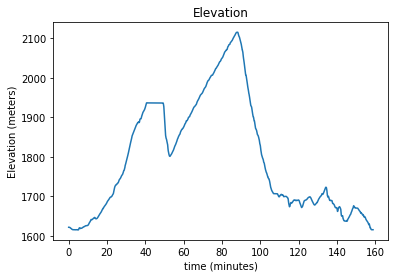

In [5]:
plt.plot((df.time-df.time[0])/np.timedelta64(1, 'm'),df.ele)
plt.title('Elevation')
plt.xlabel('time (minutes)')
plt.ylabel('Elevation (meters)')
plt.show()

# Function Definitions

In [6]:
def to_cartesian(Lat, Long,ele): # Uses kilometers
    Lat = np.deg2rad(Lat) # Convert degrees to radians for numpy trig
    Long = np.deg2rad(Long)
    
    earth_radius = 6371 # km
    radius = earth_radius + (ele/1000)
    x_pos = radius*np.cos(Lat)*np.sin(Long) # Convert spherical coordinates to cartesian
    y_pos = radius*np.cos(Lat)*np.cos(Long) # Assumes earths radius = 1
    z_pos = radius*np.sin(Lat)
    
    pos = pd.concat([x_pos,y_pos,z_pos],axis=1)
    return [np.array(x) for x in pos.values]

def distance(p1,p2):
    if p1 is None or p2 is None:
        return None
    return 1000*sum((p2-p1)**2)**.5 # Converts kilometers to meters

# Data definitions

In [7]:
df['cart'] = to_cartesian(df.lat,df.lon, df.ele)
df['sec'] = (df.time-df.time[0])/np.timedelta64(1,'s')

In [8]:
# Assumes x is strictly increasing
# Returns first order linear combination of nearest neighbors
def interpolate(sample,x,y):
    if len(x) != len(y):
        print("dim mismatch")
        return
    out = []
    j = 0
    for i in range(len(sample)):
        while x[j] < sample[i]:
            j += 1
            if j >= len(x):
                j = 0
        if x[j] == sample[i]:
            out.append(y[j])
        else:
            p1 = 1 - (sample[i]-x[j-1])/(x[j]-x[j-1])
            p2 = 1 - (x[j]-sample[i])/(x[j]-x[j-1])
            out.append(p1*y[j-1] + p2*y[j])
    return np.array(out)

# Usage
x = np.array([1700,1700.5,1701])
print(interpolate(x,df.sec, df.ele))

[1758.5  1758.55 1758.6 ]


In [9]:
# Assumes y is sampled uniformily, h is only for unit scaling
def slope(y,h):
    out = []
    j = 0
    for i in range(2,len(y)-2):
        slope = np.array(y[i+2])
        slope += 8*y[i+1]
        slope -= 8*y[i-1]
        slope -= y[i-2]
        slope /= 20*h
        out.append(slope)
    return np.array(out)

In [10]:
complete = pd.DataFrame() # Complete interpolates all missing seconds for df
x = range(int(df.sec.max())) # Uniformily spaced data allows for easier calculations over ranges
complete['ele'] = interpolate(x,df.sec,df.ele) - df.ele.min()
complete['lat'] = interpolate(x,df.sec,df.lat)
complete['lon'] = interpolate(x,df.sec,df.lon)
speed = slope(interpolate(x,df.sec, df.cart),1)
complete['speed'] = np.array([0,0] + [1000*sum(v**2)**.5 for v in speed] + [0,0] )
complete['distance'] = complete.speed.cumsum()

m=74 # rider + bike weight in kilos
g=9.8
complete['energy'] = .5*m*complete.speed**2 + m*g*complete.ele # Internal energy=[kinetic energy]+[grav energy]
delta_e = slope(complete.energy,1) # Slope of energy is power
complete['delta_energy'] = np.append(2*[0],np.append(delta_e,2*[0])) # Pad zeros due to sampling range

drag_const = 0.42
air_resistance = .5 * drag_const * complete.speed**3
rolling_constant = 0.008
rolling_resistance = rolling_constant * m * g * complete.speed

complete['friction'] = air_resistance + rolling_resistance
complete['power'] = complete.delta_energy + complete.friction
complete.head()

,ele,lat,lon,speed,distance,energy,delta_energy,friction,power
0,6.7,40.019735,-105.271550,0.000000,0.000000,4858.840000,0.000000,0.000000,0.000000
1,6.7,40.019727,-105.271551,0.000000,0.000000,4858.840000,0.000000,0.000000,0.000000
2,6.7,40.019719,-105.271553,0.896133,0.896133,4888.553039,10.506805,5.350133,15.856938
3,6.7,40.019711,-105.271554,0.833918,1.730052,4884.570526,-10.247436,4.959844,-5.287592
4,6.7,40.019703,-105.271555,0.340584,2.070635,4863.131895,-12.901707,1.984226,-10.917481


# Calibrating Friction

To test the coefficient of friction for air resistance, I rode down a hill without pedaling or braking. Additionally, wind was recorded to be < 10km/h. Thus my power should 0 watts and any change in energy is due to friction. The graph below compares the calculated $\Delta$ energy to the estimated power due to friction where the coefficient of air resistance and rolling resistance is 0.42 and 0.0008 respectivly.
![C](Show/CalibratingFriction.png)
Friction and $\Delta$ energy are approximatly equal, or at least within the variance of the data.

These values agree with data from [Cycling Power Labs](https://www.cyclingpowerlab.com/CyclingAerodynamics.aspx)  that suggests the CdA = 0.4 while riding on the hoods.

There are some other factors to account for. I conducted this test riding on the hoods, a more upright and un-aerodynamic position. This position can account for most riding, however at high speeds riders will ride in the drops, minimizing their frontal area and becoming more aerodynamic. A more clever model would adjust the coefficient of friction when a rider is likely riding in a more aerodynamic position.

However, the true test of power is on the climbs where air resistance is less significant.

# Segment analysis: Old Stage Road

(-105.31662350268817, -105.26810149731182, 40.0479269696468, 40.1026520303532)

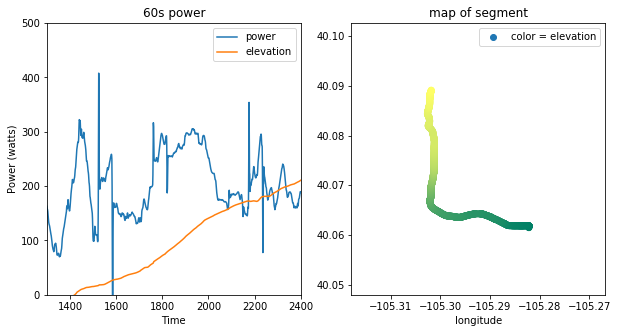

In [11]:
n=60
fig = plt.figure(figsize=(10,5))
plt.subplot('121')
plt.plot(complete.power.rolling(n).mean())
plt.plot(complete.ele-100)
#plt.plot(3.2*10*complete.speed.rolling(n).mean())

mn = 1300
mx = 2400
plt.title('{}s power'.format(n))
plt.legend(['power','elevation','speed'])
plt.xlim(mn,mx)
plt.ylim(0,500)
plt.xlabel('Time')
plt.ylabel('Power (watts)')

plt.subplot('122')
plt.scatter(complete.lon[mn:mx], complete.lat[mn:mx],c=complete.ele[mn:mx],cmap='summer')
plt.title('map of segment')
plt.xlabel('longitude')
plt.legend(['color = elevation'])
plt.axis('equal')

In [12]:
print('Average power: %.02f watts'%complete.power[mn:mx].mean())

Average power: 203.40 watts


This agrees with strava with <5% error.
![Strava](Show/Strava.png)

# Power Zones

/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 0, 'Power (watts)')

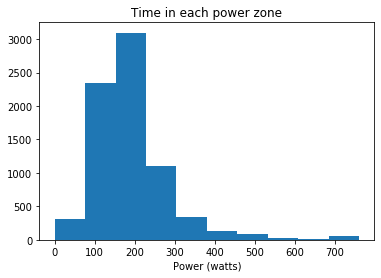

In [13]:
plt.hist(complete.power[complete.power>0].rolling(30).mean()) # Power < 0 is braking
plt.title('Time in each power zone')
plt.xlabel('Power (watts)')

# Calories Burned

In [18]:
seconds = (df.time.max()-df.time.min())/np.timedelta64(1, 's')
print('Ride length: {} seconds'.format(seconds))
avg_power = complete.power.mean()
print('Average Power: {} Watts'.format(avg_power))
joules = avg_power * seconds
Kcal = joules/4184
Kcal = Kcal/.25 # Assume the human body is 25% efficient
print("Calories burned: {} Kcal".format(Kcal))

Ride length: 9527.0 seconds
Average Power: 124.99728040174604 Watts
Calories burned: 1138.4790539076812 Kcal


# Distance

Text(0, 0.5, 'Elevation (from start)')

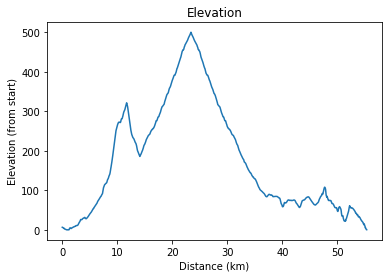

In [16]:
plt.plot(complete.distance/1000, complete.ele)
plt.title('Elevation')
plt.xlabel('Distance (km)')
plt.ylabel('Elevation (from start)')